Task 1.1

In [1]:
import requests
import re
from collections import Counter
import numpy as np

In [2]:
url = "https://www.gutenberg.org/files/1661/1661-0.txt"
text = requests.get(url).text

print("Length:", len(text))

Length: 593731


In [3]:
#filtering out just the story part
start_idx, end_idx = None, None

#finding where the first story begins and ends indexes
lines = text.splitlines()
for i, line in enumerate(lines):
    if " A SCANDAL IN BOHEMIA" in line:
        start_idx = i
        break

for i, line in enumerate(lines):
    if "END OF THE PROJECT GUTENBERG" in line.upper():
        end_idx = i
        break

# getting the text that is between the markers
if start_idx is not None and end_idx is not None:
    story_lines = lines[start_idx:end_idx]
elif start_idx is not None:
    story_lines = lines[start_idx:]
else:
    story_lines = lines

text = "\n".join(story_lines).strip()

print(f"Length: {len(text)}\n")
print(text[:800])


Length: 561653

I. A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she eclipses and
predominates the whole of her sex. It was not that he felt any emotion
akin to love for Irene Adler. All emotions, and that one particularly,
were abhorrent to his cold, precise but admirably balanced mind. He
was, I take it, the most perfect reasoning and observing machine that
the world has seen, but as a lover he would have placed himself in a
false position. He never spoke of the softer passions, save with a gibe
and a sneer. They were admirable things for the observer—excellent for
drawing the veil from men’s motives and actions. But for the trained
reasoner to admit such intrusions into his own delicate and finely
adjusted 


In [4]:
#filtering out everything other than letters numbers and .

cleaned_text = re.sub(r'[^a-zA-Z0-9 \.]', '', text)
cleaned_text = cleaned_text.lower() #converting everything to lower case
len(cleaned_text)

533032

In [5]:
#splitting into tokens(words)
cleaned = re.sub(r'[^a-zA-Z0-9\.]', ' ', text)
cleaned = re.sub(r'(\.)', r' \1 ', cleaned)  #space around every period
cleaned = re.sub(r'\s+', ' ', cleaned).strip().lower()
tokens = cleaned.split()#seperated .
print(len(tokens))
print(tokens[:50])

112095
['i', '.', 'a', 'scandal', 'in', 'bohemia', 'i', '.', 'to', 'sherlock', 'holmes', 'she', 'is', 'always', 'the', 'woman', '.', 'i', 'have', 'seldom', 'heard', 'him', 'mention', 'her', 'under', 'any', 'other', 'name', '.', 'in', 'his', 'eyes', 'she', 'eclipses', 'and', 'predominates', 'the', 'whole', 'of', 'her', 'sex', '.', 'it', 'was', 'not', 'that', 'he', 'felt', 'any', 'emotion']


In [6]:
# Keep '.' in tokens but exclude from vocab size count
tokens_wo_period = [t for t in tokens if t != '.']

# Build vocab (include <unk>)
vocab = sorted(set(tokens_wo_period) | {"<unk>", "."})  # include <unk> and .
vocab_size = len(vocab) - 1  # exclude '.' from count

# Frequency stats
freq = Counter(tokens_wo_period)
most_common_10 = freq.most_common(10)
least_common_10 = freq.most_common()[-10:]

print(f"Vocabulary size (excluding '.'): {vocab_size}\n")
print("10 most frequent words:")
for w, c in most_common_10:
    print(f"{w:>10} : {c}")

print("\n10 least frequent words:")
for w, c in least_common_10:
    print(f"{w:>10} : {c}")

# Create mappings
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}

if "<unk>" not in word_to_idx:
    unk_index = len(word_to_idx)
    word_to_idx["<unk>"] = unk_index
    idx_to_word[unk_index] = "<unk>"


Vocabulary size (excluding '.'): 7884

10 most frequent words:
       the : 5612
         i : 3037
       and : 3018
        to : 2744
        of : 2647
         a : 2640
        in : 1765
      that : 1752
        it : 1734
       you : 1502

10 least frequent words:
    seaman : 1
 blockaded : 1
 arguments : 1
     locus : 1
    standi : 1
  survived : 1
    solely : 1
 mauritius : 1
manifested : 1
   walsall : 1


In [7]:
#parameters
context_size = 5#given in example
tokens_final = tokens
vocab = sorted(set(tokens_final))
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}

#creating the sequences
X, y = [], []

for i in range(len(tokens_final) - context_size):
    context = tokens_final[i : i + context_size]
    target = tokens_final[i + context_size]
    X.append([word_to_idx[w] for w in context])
    y.append(word_to_idx[target])

X = np.array(X)
y = np.array(y)

print(f"Context size: {context_size}")
print(f"Total samples: {len(X)}\n")

#verification
for i in range(45,60):
    context_words = [idx_to_word[idx] for idx in X[i]]
    target_word = idx_to_word[y[i]]
    print(f"{' '.join(context_words)} ---> {target_word}")


Context size: 5
Total samples: 112090

that he felt any emotion ---> akin
he felt any emotion akin ---> to
felt any emotion akin to ---> love
any emotion akin to love ---> for
emotion akin to love for ---> irene
akin to love for irene ---> adler
to love for irene adler ---> .
love for irene adler . ---> all
for irene adler . all ---> emotions
irene adler . all emotions ---> and
adler . all emotions and ---> that
. all emotions and that ---> one
all emotions and that one ---> particularly
emotions and that one particularly ---> were
and that one particularly were ---> abhorrent


Task 1.2

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import re, requests


In [9]:
#ensuring that the GPU is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
#train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
#converting to torch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


In [11]:
#defining the model
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, context_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim * context_size, hidden_dim)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)           #(batch, context_size, embed_dim)
        x = x.view(x.size(0), -1)       #flatten
        x = self.act1(self.fc1(x))
        x = self.fc2(x)
        return self.log_softmax(x)

In [12]:
#starting training
embed_dim = 64
hidden_dim = 1024
epochs = 50

model = MLPTextGenerator(vocab_size, embed_dim, hidden_dim, context_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, context_size, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim * context_size, hidden_dim)
        self.act1 = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.act1(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return self.log_softmax(x)


In [15]:
embed_dim = 64
hidden_dim = 1024
epochs = 120
lr = 0.001

model = MLPTextGenerator(vocab_size, embed_dim, hidden_dim, context_size, dropout=0.3).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    preds = output.argmax(dim=1)
    train_acc = (preds == y_train).float().mean().item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_preds = val_output.argmax(dim=1)
        val_acc = (val_preds == y_val).float().mean().item()

    scheduler.step(val_loss)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Print progress
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | "
              f"Val Acc: {val_acc:.3f}")

print("Training finished.")


Epoch 1/120 | Train Loss: 9.0132 | Val Loss: 8.6514 | Val Acc: 0.004
Epoch 20/120 | Train Loss: 5.7636 | Val Loss: 6.1229 | Val Acc: 0.088
Epoch 40/120 | Train Loss: 4.9065 | Val Loss: 5.8657 | Val Acc: 0.105
Epoch 60/120 | Train Loss: 3.9894 | Val Loss: 5.8383 | Val Acc: 0.115
Epoch 80/120 | Train Loss: 3.5498 | Val Loss: 5.9173 | Val Acc: 0.118
Epoch 100/120 | Train Loss: 3.4352 | Val Loss: 5.9479 | Val Acc: 0.120
Epoch 120/120 | Train Loss: 3.4002 | Val Loss: 5.9568 | Val Acc: 0.120
Training finished.


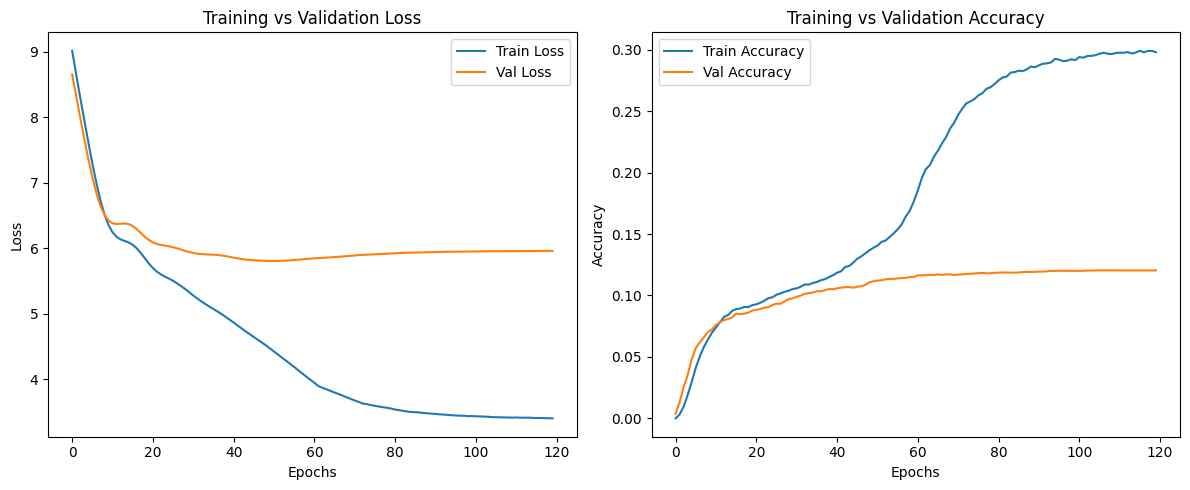

In [16]:
plt.figure(figsize=(12, 5))

# Left side Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Right side Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]*100:.2f}%")

Final Validation Loss: 5.9568
Final Validation Accuracy: 12.04%


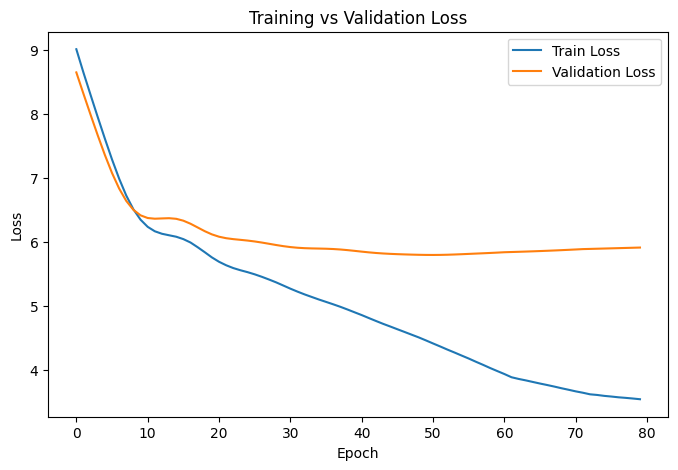

In [18]:
plt.figure(figsize=(8,5))
plt.plot(train_losses[:80], label='Train Loss')
plt.plot(val_losses[:80], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

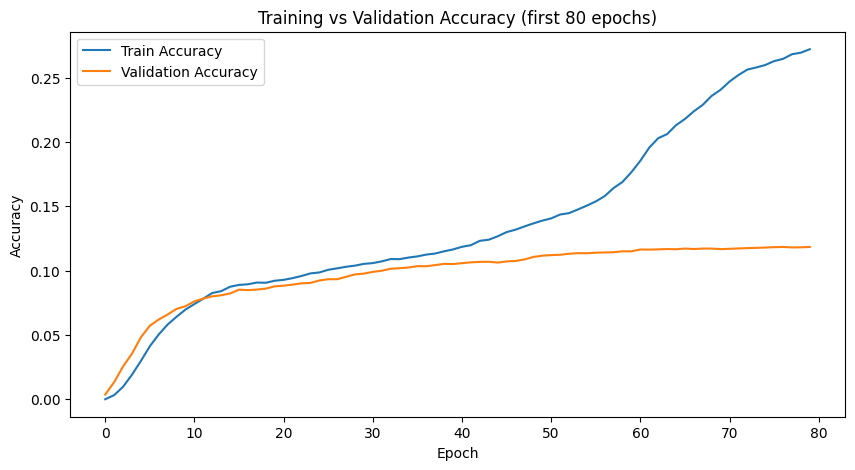

In [19]:
plt.figure(figsize=(10,5))
plt.plot(train_accs[:80], label="Train Accuracy")
plt.plot(val_accs[:80], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (first 80 epochs)")
plt.legend()
plt.show()

In [ ]:
def generate_text(model, start_seq, length=30, temperature=1.0, context_size=5):
    model.eval()
    words = start_seq.lower().split()
    for _ in range(length):
        context = words[-context_size:]
        x = [word_to_idx.get(w, word_to_idx["<unk>"]) for w in context]

        # pad if needed
        if len(x) < context_size:
            x = [word_to_idx["<unk>"]] * (context_size - len(x)) + x

        x = torch.tensor([x], dtype=torch.long).to(device)

        with torch.no_grad():
            out = model(x)
            probs = torch.exp(out / temperature).squeeze()

        next_word_idx = torch.multinomial(probs, 1).item()
        next_word = idx_to_word[next_word_idx]
        words.append(next_word)

    return " ".join(words)


In [ ]:
print("Example text generation:")
print(generate_text(model, "sherlock holmes scared of ", length=40, temperature=0.8))

Example text generation:
sherlock holmes scared of . yonder wilhelm excursion mcquire foppishness amusing instance moving . horsham andover nostrils odour that year wheels hysterical title combined bachelors foppishness suit ryder . busybody odour courage irresistible hysterical though thanks cynical mall taketh haze warsaw thanks odour that


the learning always seemed to overfit due to limited hidden layers and vocabulary size.
The generated text will not make sense with logic because we dont have enough data to train accurately.

the learning behaviour initially rises, but later saturates

1.3

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

embed_dim = 64
hidden_dim = 1024
epochs = 200
lr = 0.01

model2 = MLPTextGenerator(vocab_size, embed_dim, hidden_dim, context_size, dropout=0.3).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model2.parameters(), lr=lr, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_loss = float("inf")

for epoch in range(epochs):
    # train
    model2.train()
    optimizer.zero_grad()
    output = model2(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    preds = output.argmax(dim=1)
    train_acc = (preds == y_train).float().mean().item()

    # validate
    model2.eval()
    with torch.no_grad():
        val_output = model2(X_val)
        val_loss = criterion(val_output, y_val)
        val_preds = val_output.argmax(dim=1)
        val_acc = (val_preds == y_val).float().mean().item()

    scheduler.step(val_loss)

    # Record metrics
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # checkpoint saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
        }, 'best_checkpoint.pth')

    # progress
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | "
              f"Val Acc: {val_acc:.3f}")

print("best_checkpoint.pth")


Epoch 1/200 | Train Loss: 9.0280 | Val Loss: 6.9565 | Val Acc: 0.077
Epoch 20/200 | Train Loss: 3.2146 | Val Loss: 6.9092 | Val Acc: 0.123
Epoch 40/200 | Train Loss: 2.1089 | Val Loss: 8.1402 | Val Acc: 0.134
Epoch 60/200 | Train Loss: 1.8739 | Val Loss: 8.3923 | Val Acc: 0.135
Epoch 80/200 | Train Loss: 1.8110 | Val Loss: 8.4546 | Val Acc: 0.136
Epoch 100/200 | Train Loss: 1.7957 | Val Loss: 8.4728 | Val Acc: 0.136
Epoch 120/200 | Train Loss: 1.7943 | Val Loss: 8.4776 | Val Acc: 0.136
Epoch 140/200 | Train Loss: 1.7915 | Val Loss: 8.4791 | Val Acc: 0.136
Epoch 160/200 | Train Loss: 1.7905 | Val Loss: 8.4795 | Val Acc: 0.136
Epoch 180/200 | Train Loss: 1.7882 | Val Loss: 8.4797 | Val Acc: 0.136
Epoch 200/200 | Train Loss: 1.7885 | Val Loss: 8.4797 | Val Acc: 0.136
best_checkpoint.pth


In [22]:
embeddings = model.embedding.weight.data.cpu().numpy()

words_to_visualize = [
    "sherlock", "holmes", "watson", "detective", # related names
    "scared", "hysterical", "fear", # synonyms
    "run", "walk", "see", "hear", # verbs
    "he", "she", "they", "it", # pronouns
    "paper", "case", "hour", "seaman" # random nouns
]

In [23]:
words_to_visualize = [w for w in words_to_visualize if w in word_to_idx]
vectors = np.array([embeddings[word_to_idx[w]] for w in words_to_visualize])

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
reduced = tsne.fit_transform(vectors)

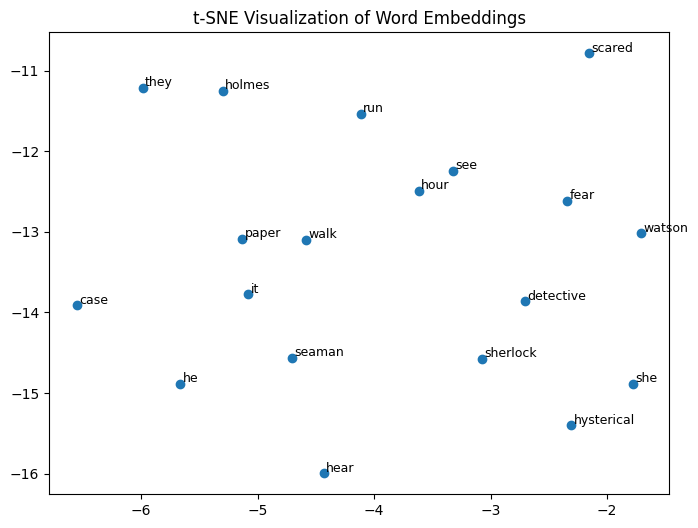

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1])

for i, word in enumerate(words_to_visualize):
    plt.text(reduced[i,0]+0.02, reduced[i,1]+0.02, word, fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


Words such as detective, sherlock and watson come close together.

similarly fear and scared are also seen together, so are some actions such as walk run see.
This shows that even though we have few training, some similarities have been found.

1.4


This task was done locally.

1.5

In [26]:
import requests, re
from collections import Counter

url = "https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt"
text = requests.get(url).text
print("Original length:", len(text))

Original length: 6206996


In [27]:
text = re.sub(r"/\*.*?\*/", "", text, flags=re.DOTALL)  # block comments
text = re.sub(r"//.*", "", text)                        # line comments

text = "\n".join([line for line in text.splitlines() if line.strip()])
code_lines = []
for line in text.splitlines():
    line = line.strip()
    # skip license, copyright, or kernel file references
    if "Copyright" in line or "Linus Torvalds" in line or "kernel/" in line:
        continue
    code_lines.append(line)

text = "\n".join(code_lines)
print("Filtered length:", len(text))

print("\nSample:\n", "\n".join(code_lines[:20]))


Filtered length: 4042490

Sample:
 #include <linux/irq.h>
#include <linux/module.h>
#include <linux/interrupt.h>
#include <linux/delay.h>
#include <linux/async.h>
#include "internals.h"
static DEFINE_MUTEX(probing_active);
unsigned long probe_irq_on(void)
{
struct irq_desc *desc;
unsigned long mask = 0;
int i;
async_synchronize_full();
mutex_lock(&probing_active);
for_each_irq_desc_reverse(i, desc) {
raw_spin_lock_irq(&desc->lock);
if (!desc->action && irq_settings_can_probe(desc)) {
if (desc->irq_data.chip->irq_set_type)
desc->irq_data.chip->irq_set_type(&desc->irq_data,
IRQ_TYPE_PROBE);


In [28]:
import re
from collections import Counter

# capture words, numbers, and symbols separately
tokens = re.findall(r"[A-Za-z_]+|\d+|[^\sA-Za-z_]", text)

# build vocab directly
vocab = sorted(set(tokens) | {"<unk>"})
vocab_size = len(vocab)

# Frequency stats
freq = Counter(tokens)
most_common_10 = freq.most_common(10)
least_common_10 = freq.most_common()[-10:]

print(f"\nVocabulary size: {vocab_size}")
print("\n10 most frequent tokens:")
for w, c in most_common_10:
    print(f"{w:>10} : {c}")

print("\n10 least frequent tokens:")
for w, c in least_common_10:
    print(f"{w:>10} : {c}")

# Create mappings
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}



Vocabulary size: 28114

10 most frequent tokens:
         ) : 79093
         ( : 79088
         ; : 77262
         , : 46668
         = : 38842
         - : 37413
         > : 35310
         * : 23600
         { : 19137
         } : 19137

10 least frequent tokens:
irq_set_percpu_devid_flags : 1
kstat_incr_irq_this_cpu : 1
kstat_irqs_usr : 1
trace_user_enter : 1
vtime_user_exit : 1
trace_user_exit : 1
CONTEXT_KERNEL : 1
__context_tracking_task_switch : 1
CONFIG_CONTEXT_TRACKING_FORCE : 1
context_tracking_init : 1


In [31]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

#Hyperparameters
context_size = 5
embed_dim = 64
hidden_dim = 1024
batch_size = 128
epochs = 300
lr = 0.001

# Prepare sequences
# Use the full token list
X, y = [], []
for i in range(len(tokens) - context_size):
    X.append([word_to_idx.get(t, word_to_idx["<unk>"]) for t in tokens[i:i+context_size]])
    y.append(word_to_idx.get(tokens[i + context_size], word_to_idx["<unk>"]))

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

#Split into train / val
split = int(0.9 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [33]:
import torch.nn as nn

class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, context_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim * context_size, hidden_dim)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_dim, vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embed(x).view(x.size(0), -1)
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.fc3(x)
        return self.log_softmax(x)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [35]:
from torch.utils.data import TensorDataset, DataLoader

In [36]:
import torch
from torch.amp import autocast, GradScaler
epochs = 150
batch_size = 512
patience = 20

In [37]:
from torch.utils.data import TensorDataset, DataLoader

# Data Loaders
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

#Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MLPTextGenerator(vocab_size, embed_dim, hidden_dim, context_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=3, min_lr=1e-6)
scaler = GradScaler(device="cuda")

# Training variables
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_loss = float("inf")
epochs = 150

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss, total_acc = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        with autocast(device_type="cuda"):
            output = model(xb)
            loss = criterion(output, yb)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        preds = output.argmax(dim=1)
        total_loss += loss.item() * xb.size(0)
        total_acc += (preds == yb).float().sum().item()

    train_loss = total_loss / len(train_ds)
    train_acc = total_acc / len(train_ds)

    # --- Validation ---
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad(), autocast(device_type="cuda"):
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            v_loss = criterion(output, yb)
            preds = output.argmax(dim=1)
            val_loss += v_loss.item() * xb.size(0)
            val_acc += (preds == yb).float().sum().item()

    val_loss /= len(val_ds)
    val_acc /= len(val_ds)
    scheduler.step(val_loss)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}")

print("model saved as 'best_model.pt'")


Using device: cuda
Epoch   1/150 | LR: 0.001000 | Train Loss: 3.7132 | Val Loss: 3.7700 | Val Acc: 0.425
Epoch  10/150 | LR: 0.000700 | Train Loss: 2.5015 | Val Loss: 3.7159 | Val Acc: 0.457
Epoch  20/150 | LR: 0.000240 | Train Loss: 2.2630 | Val Loss: 3.7880 | Val Acc: 0.462
Epoch  30/150 | LR: 0.000118 | Train Loss: 2.1714 | Val Loss: 3.8277 | Val Acc: 0.465
Epoch  40/150 | LR: 0.000040 | Train Loss: 2.1306 | Val Loss: 3.8459 | Val Acc: 0.467
Epoch  50/150 | LR: 0.000020 | Train Loss: 2.1155 | Val Loss: 3.8543 | Val Acc: 0.467
Epoch  60/150 | LR: 0.000007 | Train Loss: 2.1083 | Val Loss: 3.8585 | Val Acc: 0.468
Epoch  70/150 | LR: 0.000003 | Train Loss: 2.1046 | Val Loss: 3.8596 | Val Acc: 0.468
Epoch  80/150 | LR: 0.000001 | Train Loss: 2.1047 | Val Loss: 3.8603 | Val Acc: 0.468
Epoch  90/150 | LR: 0.000001 | Train Loss: 2.1034 | Val Loss: 3.8607 | Val Acc: 0.468
Epoch 100/150 | LR: 0.000001 | Train Loss: 2.1043 | Val Loss: 3.8612 | Val Acc: 0.468
Epoch 110/150 | LR: 0.000001 | Trai

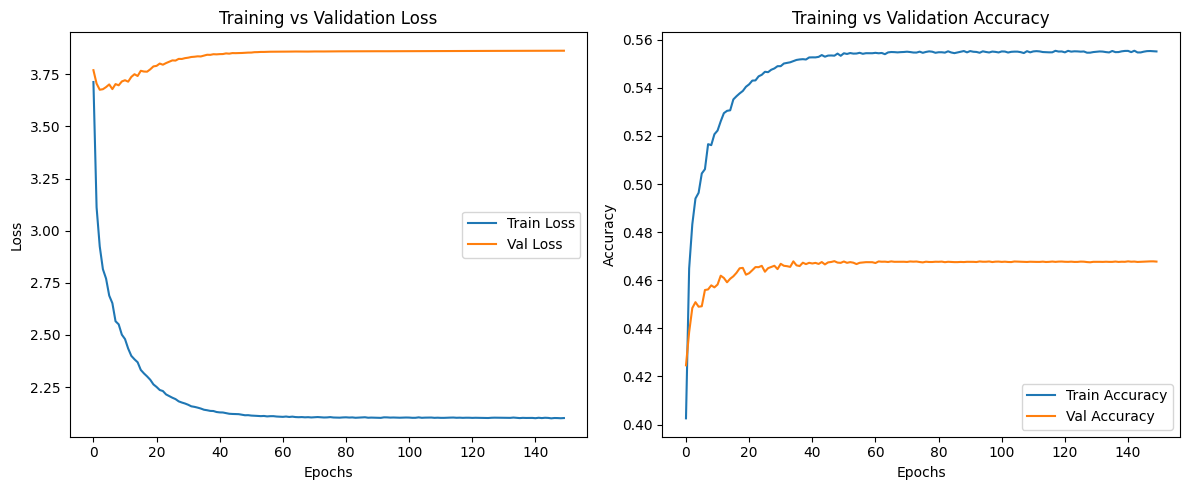

In [38]:
#plots
plt.figure(figsize=(12, 5))

# Left: Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Right: Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


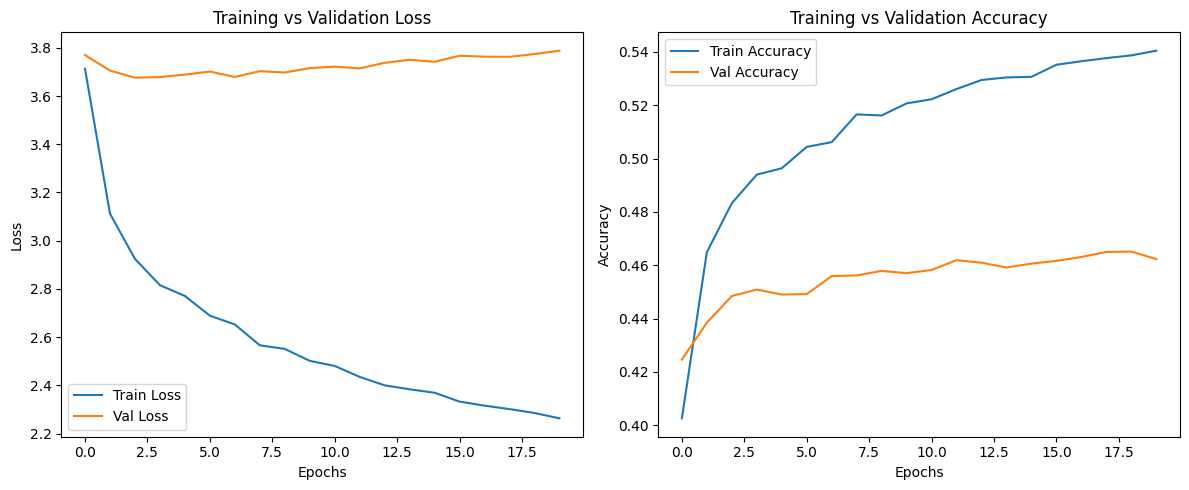

In [40]:
#plots
plt.figure(figsize=(12, 5))

# Left: Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses[:20], label='Train Loss')
plt.plot(val_losses[:20], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Right: Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs[:20], label='Train Accuracy')
plt.plot(val_accs[:20], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [41]:
def generate_code(model, start_seq, length=30, temperature=1.0, context_size=5):
    model.eval()
    words = start_seq.split()
    for _ in range(length):
        context = words[-context_size:]
        x = [word_to_idx.get(w, word_to_idx["<unk>"]) for w in context]

        if len(x) < context_size:
            x = [word_to_idx["<unk>"]] * (context_size - len(x)) + x

        x = torch.tensor([x], dtype=torch.long).to(device)

        with torch.no_grad():
            out = model(x)
            probs = torch.exp(out / temperature).squeeze()
            next_word_idx = torch.multinomial(probs, 1).item()

        next_word = idx_to_word[next_word_idx]
        words.append(next_word)

    return " ".join(words)


In [42]:
print("\nExample code generation:")
print(generate_code(model, "static int ", length=40, temperature=0.8))



Example code generation:
static int do_sysvsem ( struct file * filp , const char __user * ubuf , size_t cnt , loff_t * ppos ) { unsigned long flags ; raw_spin_lock_irqsave ( & logbuf_lock , flags ) ; ret = __trace_graph_entry ( tr ) ;


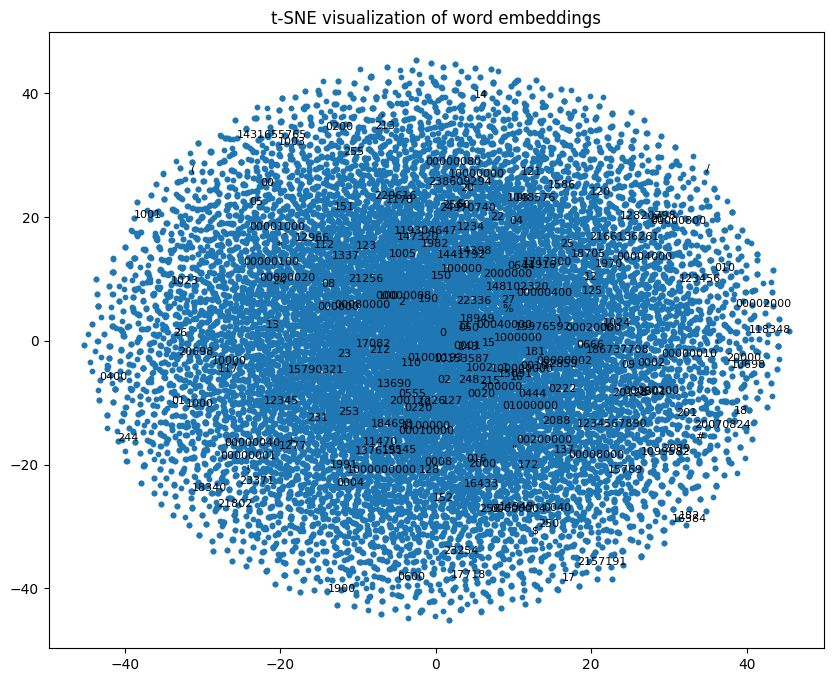

In [43]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract embeddings
embeddings = model.embed.weight.detach().cpu().numpy()

# Reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10)
for i, word in enumerate(list(idx_to_word.values())[:200]):  # plot a few labels
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], word, fontsize=8)
plt.title("t-SNE visualization of word embeddings")
plt.show()


#for category 1,

The model learns meaningful embeddings more easily since natural language has smoother syntax, redundancy, and predictable patterns.

the validation loss, 5.96, and accuracy, 12%, show that while the model captures some structure, it struggles with full sentence, probably due to vocabulary richness.

natural language is more learnable for embeddings because it contains semantic regularities.

#for category 2,

The embedding appears more random, showing difficulty in capturing structure.

this is because code syntax is rigid and hierarchical, that simple sequence models would struggle to learn.

here, the validation accuracy is higher, 46.8%, this is mostly due to pattern repetition in tokens (common keywords).

The large dataset size and complex token structure make learning slower


To summarize, it is easier for small models to learn natual laguages than complicated syntax based programming languages.